# Presto card usage
Data from my prestocard.ca account

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from fbprophet import Prophet

In [2]:
## Load data
presto = pd.read_csv("presto_trans.csv",
                    converters={'Amount': lambda s: float(s.replace('$', ''))})
presto['Date'] = pd.to_datetime(presto['Date'])
presto.columns = ["Date","TransitAgency","Location,","Type","ServiceClass","Discount","Amount","Balance"]

## Only count TTC (essentially exclude trips to airport)
presto = presto.query('TransitAgency == "Toronto Transit Commission"')

### Data exploration

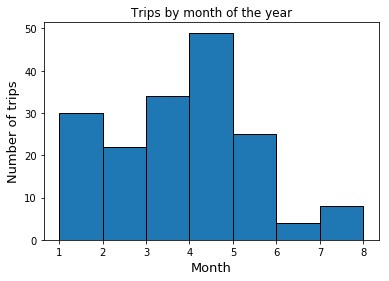

In [3]:
plt.hist(presto['Date'].apply(lambda x: x.month), bins=7, edgecolor='k')
plt.xlabel('Month', fontsize=13)
plt.ylabel('Number of trips',fontsize=13)
plt.title('Trips by month of the year')
plt.show()

I was out of town for 10 days in February. Started biking in May

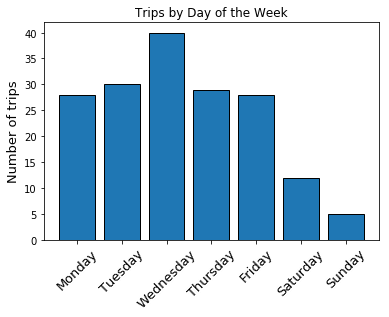

In [4]:
by_weekday = presto.groupby(presto['Date'].dt.weekday_name).count().Date
by_weekday = by_weekday.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
x = np.arange(len(by_weekday))
plt.bar(x, by_weekday, edgecolor='k')
plt.xticks(x, by_weekday.index)
plt.xticks(rotation=45)
plt.xticks(fontsize=13)
plt.ylabel('Number of trips',fontsize=13)
plt.title('Trips by Day of the Week')
plt.show()

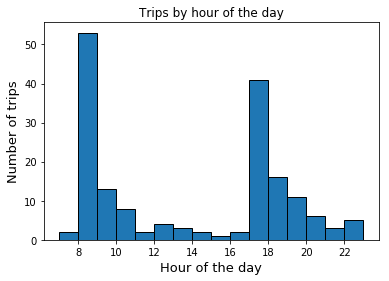

In [5]:
presto['Hour'] = presto['Date'].apply(lambda x: x.hour)

min_hour = presto['Hour'].min()
max_hour = presto['Hour'].max()

plt.hist(presto.Hour, bins= (max_hour-min_hour), edgecolor='k')
plt.xlabel('Hour of the day', fontsize=13)
plt.ylabel('Number of trips',fontsize=13)
plt.title('Trips by hour of the day')
plt.show()

### Card usage vs. time

Text(0.5,0,u'Date')

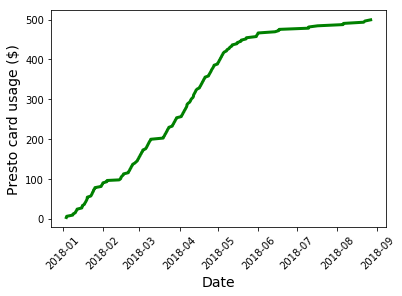

In [6]:
fpp = presto.groupby('Date').sum()[['Amount']]
plt.plot(np.cumsum(fpp), color='g', linewidth=3, label='Actual')
plt.xticks(rotation=45)
plt.ylabel('Presto card usage ($)', fontsize=14)
plt.xlabel('Date', fontsize=14)

## Now fit a simple line
Only up to May 8th, the date when I started biking

In [7]:
## Fit a line to data before 2018-05-08
presto_bf = presto.query('Date < "2018-05-08"')
fpp_bf = presto_bf.groupby('Date').sum()[['Amount']]
regr = LinearRegression()
regr.fit(fpp_bf.index.values.reshape(-1,1), np.cumsum(fpp_bf.Amount).values.reshape(-1,1))
rng = pd.date_range('1/1/2018', periods=80, freq='3D')
pred = regr.predict(rng.values.astype(float).reshape(-1,1))

/Users/elder/my-virtualenv/lib/python2.7/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


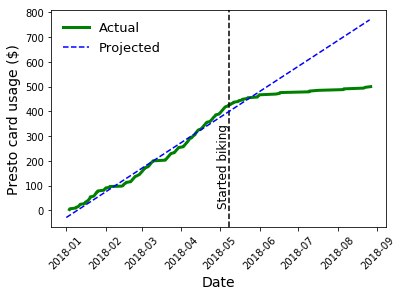

In [8]:
## Plot data
fpp = presto.groupby('Date').sum()[['Amount']]
plt.plot(np.cumsum(fpp), color='g', linewidth=3, label='Actual')
plt.xticks(rotation=45)
plt.ylabel('Presto card usage ($)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.axvline('2018-05-08', color='k', linestyle='--')
plt.plot(rng, pred, color='b', linestyle='--', label='Projected')
plt.text('2018-04-29',310,'Started biking', rotation=90, fontsize=12)
plt.legend(frameon=False, fontsize=13)
plt.show()

In [9]:
pred[-1] - np.cumsum(fpp.Amount).values[-1]

array([269.86809615])

### Have saved ~$270 so far. Pretty good!
## Now using Facebook Prophet

In [17]:
%%tail

DS = np.cumsum(fpp.Amount).values
Y = fpp.index.values

df = pd.DataFrame(DS, Y).reset_index()
df.columns = ['ds','y']

m = Prophet()
m.fit(df)

UsageError: Cell magic `%%tail` not found.


In [16]:
## The range of dates for which a prediction is requested
future = m.make_future_dataframe(periods=90) ## 90 days after the end of the training period
future.tail()

,ds
257,2018-11-20 18:56:06
258,2018-11-21 18:56:06
259,2018-11-22 18:56:06
260,2018-11-23 18:56:06
261,2018-11-24 18:56:06


In [12]:
%%time 

## Get the actual prediction
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
257,2018-11-20 18:56:06,604.639282,531.232883,679.158207
258,2018-11-21 18:56:06,607.309560,536.365594,684.152913
259,2018-11-22 18:56:06,608.884889,535.962392,685.076406
260,2018-11-23 18:56:06,612.534253,538.640154,692.776877
261,2018-11-24 18:56:06,610.971346,532.330395,689.751435


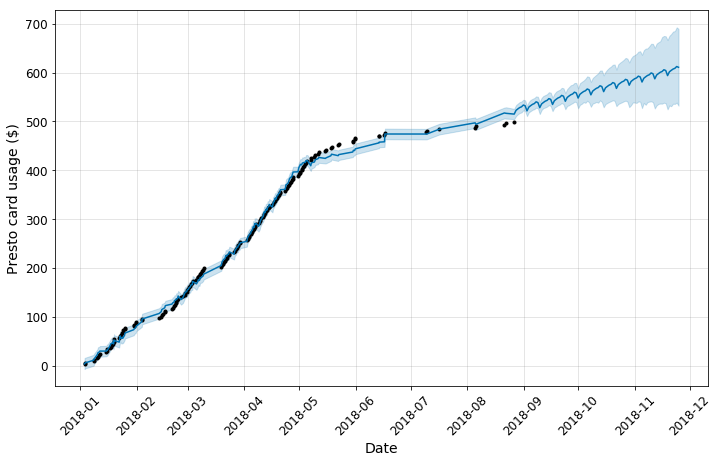

In [13]:
fig1 = m.plot(forecast)
plt.xlabel('Date', fontsize = 14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Presto card usage ($)', fontsize=14)
plt.show()

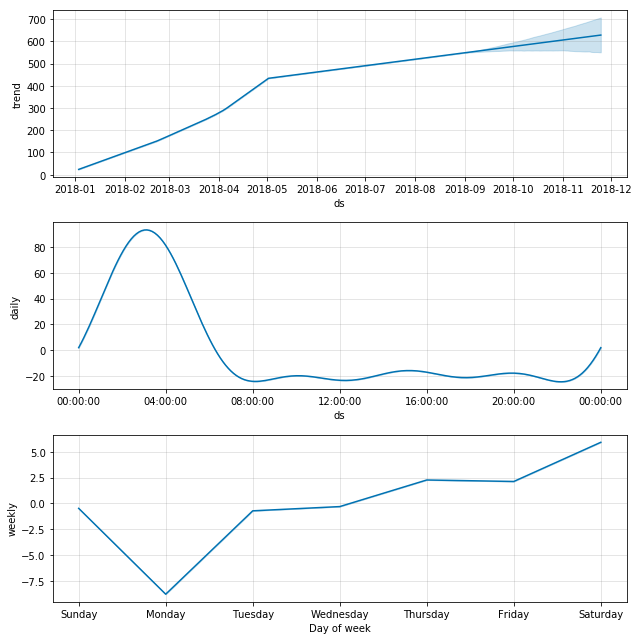

In [14]:
fig2 = m.plot_components(forecast)

### Observations:
- Prophet is **very succesful** in picking up the monthly trend change in May and adjusting the model accordingly.
- It shows a peak in the daily trend at 3am. Could it be that it converts the timestamps to UTC and that pick corresponds to the 8am morning commute?
- The weekly seasonality trend doesn't seem to correlate to what we saw earlier.

#### Plotting the prediction envelope using matplotlib

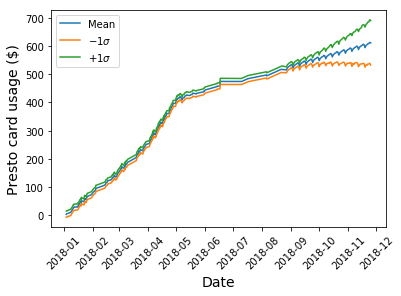

In [15]:
plt.plot(forecast.ds, forecast.yhat, label='Mean')
plt.plot(forecast.ds, forecast.yhat_lower, label='$-1\sigma$')
plt.plot(forecast.ds, forecast.yhat_upper, label='$+1\sigma$')

plt.ylabel('Presto card usage ($)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(rotation=45)

plt.legend()
plt.show()